In [47]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from data import DataTransformer, DataExtractor

Data extraction relies on the functionalities provided by the classes delineated in the <b>data</b> notebook. The extracted data serves the purpose of both training and testing the model.

In [3]:
extractor = DataExtractor('Train/train_benign', 'Train/train_malign',
                          'Test/test_benign', 'Test/test_malign')

In [4]:
train_data, train_labels, test_data, test_labels = extractor.generate_train_test_data()

The <b>CNNModel</b> class is a versatile tool designed for creating, training, and utilizing <b>melanoma classifiers</b><br>
The class provides the flexibility to utilize pre-trained models or create entirely new models through its <b>create_model</b> method. The method serves as a foundational template that can be customized in multiple ways to optimize performance. <br>

Using the <b>fit()</b> method, the class enables the training of CNN models on provided training datasets. <br>
Additionally, the <b>evaluate()</b> method allows for the assessment of model performance on separate testing datasets, providing metrics such as loss and accuracy. <br>
The <b>predict()</b> method enables making predictions on new datasets using the trained model.<br>

Furthermore, the <b>predict_for_image()</b> method simplifies the task of predicting the classification of individual images, while also indicating the confidence level associated with the classification made by the model.

In [28]:
class CNNModel:
    def __init__(self, model: keras.models.Model = None,
                 train_data: np.ndarray = None,
                 train_labels: np.ndarray = None,
                 test_data: np.ndarray = None,
                 test_labels: np.ndarray = None):
        self._label_names = ['Benign', 'Malignant']
        self._train_data = train_data
        self._train_labels = train_labels
        self._test_data = test_data
        self._test_labels = test_labels

        if model is not None:
            self._model = model
        else:
            self.create_model()

    def create_model(self):
        # Convolutional layers
        self._model = keras.models.Sequential()
        self._model.add(keras.layers.Conv2D(64, (3, 3),
                                            activation='relu',
                                            input_shape=(64, 64, 3)))
        self._model.add(keras.layers.MaxPooling2D((2, 2)))
        self._model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
        self._model.add(keras.layers.MaxPooling2D((2, 2)))
        self._model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
        self._model.add(keras.layers.MaxPooling2D((2, 2)))
        self._model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

        # Dense layers
        self._model.add(keras.layers.Flatten())
        self._model.add(keras.layers.Dense(64, activation='relu'))
        self._model.add(keras.layers.Dense(1, activation='sigmoid'))

        base_learning_rate = 0.0001
        self._model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=['accuracy'])

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, model: keras.models.Model):
        self._model = model

    @property
    def train_dataset(self):
        return self._train_data, self._train_labels

    @train_dataset.setter
    def train_dataset(self, train_data: np.ndarray, train_labels: np.ndarray):
        if train_data is None or train_labels is None:
            raise Exception('Train dataset can not contain None elements')
        if len(train_data) != len(train_labels):
            raise Exception('Training data and labels array must be of same length')
        self._train_data = train_data
        self._train_labels = train_labels

    @property
    def test_dataset(self):
        return self._test_data, self._train_labels

    @test_dataset.setter
    def test_dataset(self, test_data: np.ndarray, test_labels: np.ndarray):
        if test_data is None or test_labels is None:
            raise Exception('Test dataset can not contain None elements')
        if len(test_data) != len(test_labels):
            raise Exception('Testing data and labels array must be of same length')
        self._test_data = test_data
        self._test_labels = test_labels

    def summary(self):
        self._model.summary()

    def fit(self, epochs=10, batch_size=128):
        if self._train_data is not None and self._train_labels is not None:
            if len(self._train_data) == len(self._train_labels):
                self._model.fit(self._train_data, self._train_labels,
                                epochs=epochs, batch_size=batch_size)
            else:
                raise Exception('Training data and labels do not match')
        else:
            raise Exception('No training dataset provided')

    def evaluate(self, batch_size=128):
        if self._test_data is not None and self._test_labels is not None:
            if len(self._test_data) == len(self._test_labels):
                loss, accuracy = self._model.evaluate(self._test_data,
                                                      self._test_labels,
                                                      batch_size=batch_size)
                return loss, accuracy
            else:
                raise Exception('Testing data and labels do not match')
        raise Exception('No testing dataset provided')

    def predict(self, dataset: np.ndarray):
        return self._model.predict(dataset)

    def predict_for_image(self, image_path: str,
                          resize_dimension: int = 64,
                          interpolation: bool = True,
                          denoise: bool = True):
        img = DataTransformer.transform_image(image_path,
                                              resize_dimension,
                                              interpolation,
                                              denoise)
        img = np.expand_dims(img, axis=0)
        prediction = self._model.predict(img)[0][0]
        if prediction >= 0.5:
            prediction_label = self._label_names[1]
            confidence = prediction
        else:
            prediction_label = self._label_names[0]
            confidence = 1 - prediction

        return prediction_label, confidence

    def save(self, name: str):
        self._model.save(name)

<b>CNNModel</b> instances can be instantiated either by supplying training and testing data or by providing a pre-trained model.

In [7]:
model = CNNModel(train_data=train_data, train_labels=train_labels,
                 test_data=test_data, test_labels=test_labels)

The <b>summary()</b> method enables visualization of the neural network's structure.

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

<br><b>Training and testing of the model</b>

In [9]:
model.fit(epochs=10)

Epoch 1/10


2024-03-03 14:51:48.095746: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 583876608 exceeds 10% of free system memory.
2024-03-03 14:51:48.512919: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 583876608 exceeds 10% of free system memory.
2024-03-03 14:51:49.654413: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-03 14:51:51.150871: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f098962d7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-03 14:51:51.150915: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-03-03 14:51:51.157107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709477511.228959   28284 device_

93/93 [==============================] - 15s 87ms/step - loss: 0.5841 - accuracy: 0.6714
Epoch 2/10
93/93 [==============================] - 4s 46ms/step - loss: 0.4302 - accuracy: 0.7957
Epoch 3/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3920 - accuracy: 0.8199
Epoch 4/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3801 - accuracy: 0.8286
Epoch 5/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3643 - accuracy: 0.8364
Epoch 6/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3619 - accuracy: 0.8347
Epoch 7/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3403 - accuracy: 0.8503
Epoch 8/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3369 - accuracy: 0.8529
Epoch 9/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3408 - accuracy: 0.8480
Epoch 10/10
93/93 [==============================] - 4s 46ms/step - loss: 0.3282 - accuracy: 0.8543


In [10]:
test_loss, test_acc = model.evaluate()

16/16 [==============================] - 1s 79ms/step - loss: 0.3187 - accuracy: 0.8640


<br><b>Saving a model</b>

In [11]:
model.save('derm_lens.keras')

<br><b>Making predictions on sets of images</b><br>
Please note that the output neuron of the neural network employs the <b>sigmoid activation function</b> to constrain the output within the range of 0 to 1. Consequently, a value closer to 0 indicates a <b>benign</b> classification, whereas a value closer to 1 indicates a <b>malignant</b> classification.

In [12]:
predictions = model.predict(test_data)

63/63 [==============================] - 1s 12ms/step


In [14]:
print(predictions[1])

[0.23560499]


<br><b>Obtaining predictions and confidence levels for individual images.</b>

In [45]:
result, confidence = model.predict_for_image('Test/test_benign/6303.jpg')

1/1 [==============================] - 0s 19ms/step


Prediction:  Benign
Confidence:  0.8962490931153297


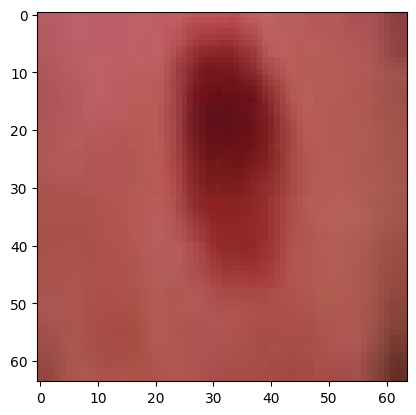

In [49]:
plt.imshow(mpimg.imread('Test/test_benign/6303.jpg'))
print("Prediction: ", result)
print("Confidence: ", confidence)

1/1 [==============================] - 0s 20ms/step
Prediction:  Malignant
Confidence:  0.9936528


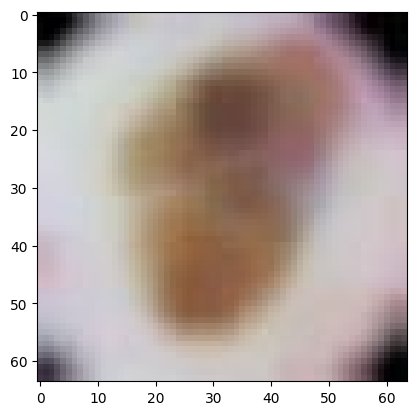

In [56]:
result, confidence = model.predict_for_image('Test/test_malign/5620.jpg')
plt.imshow(mpimg.imread('Test/test_malign/5620.jpg'))
print("Prediction: ", result)
print("Confidence: ", confidence)